## Evaluating Predictive Performance

Topics presented here:

- Discussion on popular performance metrics. For prediction, metrics include Average Error, MAPE, and RMSE (based on the validation data). For classification tasks, metrics based on the confusion matrix include overall accuracy, specificity and sensitivity, and metrics that account for misclassification costs.

- Relation between the choice of cutoff value and classification performance, and present the ROC (Receiver Operating Characteristic) curve, which is a popular chart for assessing method performance at different cutoff values.
 
- Lift charts. Used when the goal is to accurately classify the most interesting or important records, called ranking, rather than accurately classify the entire sample (e.g., the 10% of customers most likely to respond to an offer, or the 5% of claims most likely to be fraudulent)

- the usefulness of comparing metrics based on the validation data to those based on the training data for the purpose of detecting overfitting. While some differences are expected, extreme differences can be indicative of overfitting.

# Modules

In [1]:
import math
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc

import matplotlib.pylab as plt
from utils import regression_summary

## Introduction 

Three main types of outcomes of interest are:

- Predicted numerical value: when the outcome variable is numerical (e.g., house price)

- Predicted class membership: when the outcome variable is categorical (e.g., buyer/nonbuyer)

- Propensity: the probability of class membership, when the outcome variable is categorical (e.g., the propensity to default)

Prediction methods are used for generating numerical predictions, while classification methods (“classifiers”) are used for generating propensities and, using a cutoff value on the propensities, we can generate predicted class memberships.

A subtle distinction to keep in mind is the two distinct predictive uses of classifiers: one use, classification, is aimed at predicting class membership for new records. The other, ranking, is detecting among a set of new records the ones most likely to belong to a class of interest.

### Evaluating Predictive Performance 

First, let us emphasize that predictive accuracy is not the same as goodness-of-fit. Classical statistical measures of performance are aimed at finding a model that fits well to the data on which the model was trained. In data mining, we are interested in models that have high predictive accuracy when applied to new records.

Measures such as $R^2$ and standard error of estimate are common metrics in classical regression modeling, and residual analysis is used to gauge goodness-of-fit in that situation. However, these measures do not tell us much about the ability of the model to predict new records.

For assessing prediction performance, several measures are used. In all cases, the measures are based on the validation set, which serves as a more objective ground than the training set to assess predictive accuracy. This is because records in the validation set are more similar to the future records to be predicted, in the sense that they are not used to select predictors or to estimate the model parameters. Models are trained on the training set, applied to the validation set, and measures of accuracy then use the prediction errors on that validation set.

### Naive Benchmark: The Average

The benchmark criterion in prediction is using the average outcome value (thereby ignoring all predictor information). In other words, the prediction for a new record is simply the average across the outcome values of the records in the training set ($\bar{y}$). This is sometimes called a naive benchmark. A good predictive model
should outperform the benchmark criterion in terms of predictive accuracy.

### Prediction Accuracy Measures

The prediction error for record $i$ is defined as the difference between its actual outcome value and its predicted outcome value: $e_{i} = y_{i} - \hat{y}_i$

A few popular numerical measures of predictive accuracy are:

- **MAE** (mean absolute error/deviation) = $\frac{1}{n}\sum^{n}_{i=1}|{e}|$

    This gives the magnitude of the average absolute error.


- **Mean Error** = $\frac{1}{n}\sum^{n}_{i=1}e_{i}$

    This measure is similar to MAE except that it retains the sign of the errors, so that negative errors cancel out positive errors of the same magnitude. It therefore gives an indication of whether the predictions are on average over - or underpredicting the outcome variable.


- **MPE** (mean percentage error) = 100 x $\frac{1}{n}\sum^{n}_{i=1}\frac{e_{i}}{y_{i}}$

    This gives the percentage score of how predictions deviate from the actual values (on average), taking into account the direction of the error.


- **MAPE** (mean absolute percentage error) = 100 x $\frac{1}{n}\sum^{n}_{i=1}|\frac{e_{i}}{y_{i}}|$

    This measure gives a percentage score of how predictions deviate (on average) from the actual values.


- **RMSE** (root mean squared error) = $\sqrt{\frac{1}{n}\sum^{n}_{i=1}e^{2}_{i}}$

    This is similar to the standard error of estimate in linear regression, except that it is computed on the validation data rather than on the training data. It has the same units as the outcome variable.


Such measures can be used to compare models and to assess their degree of prediction accuracy. Note that all these measures are influenced by outliers. To check outlier influence, we can compute median-based measures (and compare to the above mean-based measures) or simply plot a histogram or boxplot of the errors. Plotting the prediction errors’ distribution is in fact very useful and can highlight more information than the metrics alone.

To illustrate the use of predictive accuracy measures and charts of prediction error distribution, consider the error metrics and charts that follows:

In [2]:
# reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = pd.read_csv("../datasets/ToyotaCorolla.csv")

# create a list of predictor variables by removing output variables and text columns
excluded_columns = ("Price", "Id", "Model", "Fuel_Type", "Color")
predictors = [s for s in car_df.columns if s not in excluded_columns]
outcome = "Price"

# partition data
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train linear regression model
reg = LinearRegression()
reg.fit(train_X, train_y)

# evaluate performance
# training
regression_summary(train_y, reg.predict(train_X))
# validation
regression_summary(valid_y, reg.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1121.0606
            Mean Absolute Error (MAE) : 811.6770
          Mean Percentage Error (MPE) : -0.8630
Mean Absolute Percentage Error (MAPE) : 8.0054

Regression statistics

                      Mean Error (ME) : 97.1891
       Root Mean Squared Error (RMSE) : 1382.0352
            Mean Absolute Error (MAE) : 880.1396
          Mean Percentage Error (MPE) : 0.0138
Mean Absolute Percentage Error (MAPE) : 8.8744


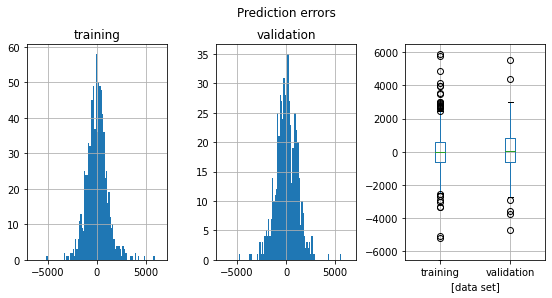

In [3]:
pred_error_train = pd.DataFrame({
    "residual": train_y - reg.predict(train_X),
    "data set": "training"})

pred_error_valid = pd.DataFrame({
    "residual": valid_y - reg.predict(valid_X),
    "data set": "validation"})

boxdata_df = pred_error_train.append(pred_error_valid, ignore_index=True)

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(9, 4)

common = {"bins": 100, "range": [-6500, 6500]}
pred_error_train.hist(ax=axes[0], **common)
pred_error_valid.hist(ax=axes[1], **common)
boxdata_df.boxplot(ax=axes[2], by="data set")

axes[0].set_title("training")
axes[1].set_title("validation")
axes[2].set_title(" ")
axes[2].set_ylim(-6500, 6500)

plt.suptitle("Prediction errors")
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35)
plt.show()

These are the result of fitting a certain predictive model to prices of used Toyota Corolla cars. The training set includes 861 cars and the validation set includes 575 cars. Results are displayed separately for the training and validation sets. We can see from the histogram and boxplot corresponding to the validation set that most errors are in the [−2000, 2000] range.